In [107]:
import pandas as pd
from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torchmetrics.functional.classification import accuracy, f1_score, precision, recall

import numpy as np

import torch
from torch import nn

from sentence_transformers import SentenceTransformer

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using CUDA!')
else:
    device = torch.device('cpu')
    print("Using CPU!")

Using CPU!


In [108]:
df_manifesto = pd.read_pickle('data\df_manifesto_final.pkl')
new_labels = pd.read_csv('data/df_spendings_unlabeled.csv', sep=';', encoding='utf-8-sig', index_col=0)


In [ ]:
df_manifesto.loc[new_labels.index, "label"] = new_labels["label"]

In [109]:
df_manifesto.loc[df_manifesto["label"].isna(), "label"] = np.nan
random_indices = df_manifesto[df_manifesto["label"].isna()].sample(2000, random_state=42).index
df_manifesto.loc[random_indices, "label"] = 0
df_spendings = df_manifesto.copy()
df_spendings = df_spendings.dropna(subset=["label"])
df_spendings["label"] = df_spendings["label"].astype(int)

In [110]:
sentences, labels = df_spendings["text"].tolist(), df_spendings["label"].values
num_classes = 3
model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v2').to(device)

In [111]:
with torch.no_grad():
    embeddings = model.encode(sentences, convert_to_tensor=True).cpu().numpy()

np.save("data\embeddings.npy", embeddings)
np.save("data\labels.npy", labels)

In [95]:
embeddings = np.load("data\embeddings.npy")
labels = np.load("data\labels.npy")

The Dataset class is a custom implementation for managing data, likely intended for use with PyTorch's DataLoader. It takes two inputs during initialization: embeddings and labels. The embeddings represent the feature vectors for the data points, while labels are the corresponding target values (e.g., class labels for classification).

This class encapsulates the logic for a simple feedforward neural network classifier, making it reusable and modular. Together, these two classes form the foundation for a machine learning pipeline, where the Dataset class handles data preparation and the ClassifierHead class defines the model architecture.

The __len__ method returns the number of data points in the dataset, which is determined by the length of the labels list.
The __getitem__ method retrieves a single data point and its label based on the provided index (idx). It converts the embeddings and labels at the specified index into PyTorch tensors with appropriate data types (float32 for embeddings and int64 for labels). This ensures compatibility with PyTorch models and training pipelines.
This class is essential for preparing data in a format that can be efficiently processed during training or evaluation.

The ClassifierHead class defines a neural network module for classification tasks. It inherits from PyTorch's nn.Module and is designed to process input feature vectors and produce predictions for two classes (binary classification).

The constructor (__init__) initializes a sequential model (nn.Sequential) consisting of:

A fully connected layer (nn.Linear) that maps the input features to 1024 dimensions.
A ReLU activation function (nn.ReLU) to introduce non-linearity.
A dropout layer (nn.Dropout) with a dropout rate of 0.2 to reduce overfitting by randomly zeroing some of the activations during training.
Another fully connected layer that maps the 1024-dimensional features to 2 output dimensions, corresponding to the two classes.
The forward method defines how the input data flows through the network. It takes an input tensor x, passes it through the sequential layers, and returns the output tensor out.


In [113]:
class Dataset:

    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        embeddings = torch.tensor(self.embeddings[idx], dtype=torch.float32)
        labels = torch.tensor(self.labels[idx], dtype=torch.int64)
        return embeddings, labels

class ClassifierHead(nn.Module):

    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes), # Hier dann num_classes statt 2.
        )

    def forward(self, x):
        out = self.classifier(x)
        return out

The provided function, model_pass, is a utility function designed to handle a single pass (either training or evaluation) of a machine learning model. It takes several arguments: model (the neural network to be trained or evaluated), criterion (the loss function), loader (a data loader providing batches of data), optimizer (used for updating model parameters during training), and train (a boolean indicating whether the pass is for training or evaluation).

The function begins by setting the model's mode using model.train() or model.eval(), depending on whether the train flag is True or False. This ensures that the model behaves appropriately, such as enabling or disabling dropout layers during training or evaluation, respectively.

It initializes empty lists to track losses, predictions (preds), and targets (targs). The function then iterates over the data loader, which provides batches of features and labels. These are moved to the appropriate device (e.g., CPU or GPU) for computation. The torch.set_grad_enabled(train) context manager ensures that gradients are only computed during training, saving memory and computation during evaluation.

Within the loop, the model processes the input features to produce outputs, and the loss is computed using the provided criterion. If the pass is for training, the optimizer is used to update the model's parameters: gradients are computed via loss.backward(), and the optimizer steps forward with optimizer.step(). Predictions are obtained by taking the index of the maximum value along the output's last dimension (torch.argmax), and both predictions and labels are detached from the computation graph to avoid unnecessary memory usage.

After processing all batches, the predictions and targets are concatenated into single tensors using torch.cat. The function then computes several evaluation metrics: accuracy, F1 score, precision, and recall, using helper functions like binary_accuracy, binary_f1_score, etc. These metrics are calculated for binary classification tasks, where the model predicts one of two possible classes.

Finally, the function returns a dictionary containing the average loss and the computed metrics. This structure makes it easy to monitor the model's performance during training and evaluation, providing insights into how well the model is learning and generalizing.

In [114]:
def model_pass(num_classes, model, criterion, loader, optimizer=None, train=True):
    if train:
        model.train()
    else:
        model.eval()

    losses = []

    preds = []
    targs = []

    for features, labels in loader:
        features = features.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(train):
            outputs = model(features)
            loss = criterion(outputs, labels)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        pred = torch.argmax(outputs, dim=1)

        preds.append(pred.detach())
        targs.append(labels.detach())

        losses.append(loss.item())

    preds = torch.cat(preds)
    targs = torch.cat(targs)

    acc = accuracy(preds, targs, task="multiclass", num_classes=num_classes)
    f1 = f1_score(preds, targs, task="multiclass", num_classes=num_classes)
    prec = precision(preds, targs, task="multiclass", num_classes=num_classes)
    rec = recall(preds, targs, task="multiclass", num_classes=num_classes)

    return {
        "loss": np.mean(losses),
        "accuracy": acc.item(),
        "f1": f1.item(),
        "precision": prec.item(),
        "recall": rec.item(),
    }



This code sets up the training pipeline for a binary classification task using PyTorch. It begins by instantiating the ClassifierHead model with an input dimension of 512, which corresponds to the size of the feature vectors (embeddings). The model is moved to the appropriate device (e.g., CPU or GPU) for computation.

The dataset is split into training and validation sets using the train_test_split function. The test_size=0.1 parameter ensures that 10% of the data is reserved for validation, while the remaining 90% is used for training. The stratify=labels argument ensures that the class distribution in the training and validation sets matches the original dataset, which is important for imbalanced datasets. The random_state=42 ensures reproducibility by fixing the random seed.

To handle class imbalance, the compute_class_weight function calculates weights for each class based on their frequency in the training data. These weights are then used to create sample weights for each training example, ensuring that underrepresented classes are sampled more frequently during training. A WeightedRandomSampler is used in the DataLoader for the training dataset to implement this sampling strategy. The validation dataset, on the other hand, is loaded with a simple shuffle mechanism.

The Dataset class is used to wrap the training and validation data, making it compatible with PyTorch's DataLoader. The DataLoader batches the data and, in the case of the training set, uses the weighted sampler to draw 500 samples per epoch with replacement. The batch size for both loaders is set to 64.

The training process is configured to run for 250 epochs. The loss function used is CrossEntropyLoss, which is suitable for multi-class classification tasks (including binary classification). The optimizer is AdamW, a variant of the Adam optimizer that includes weight decay for better regularization. The learning rate is set to 1e-4. A learning rate scheduler, CosineAnnealingLR, is also defined to gradually reduce the learning rate over the course of training, with a minimum value of 1e-6. This helps the model converge more effectively by fine-tuning the learning rate as training progresses.

In [112]:
num_classes = 3

classifier = ClassifierHead(input_dim=512, num_classes=num_classes).to(device)

train_features, valid_features, train_labels, valid_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=42, shuffle=True, stratify=labels
)

class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
train_sample_weights = np.array([class_weights[label] for label in train_labels])

train_dataset = Dataset(train_features, train_labels)
valid_dataset = Dataset(valid_features, valid_labels)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    sampler=torch.utils.data.WeightedRandomSampler(
        train_sample_weights, 
        500,
        replacement=True
    ),
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, 
    batch_size=64, 
    shuffle=True
)

epochs = 250

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

In [116]:
pbar = tqdm(range(epochs))

best_f1 = 0
for e in pbar:

    train_metrics = model_pass(num_classes, classifier, criterion, train_loader, optimizer, train=True)
    valid_metrics = model_pass(num_classes, classifier, criterion, valid_loader, optimizer=None, train=False)
    scheduler.step()

    if valid_metrics["f1"] > best_f1:
        best_f1 = valid_metrics["f1"]
        torch.save(classifier.state_dict(), "classifier.pt")
    
    pbar.set_description(f"Train F1 {train_metrics['f1']:.4f} - Valid F1 {best_f1:.4f}")

Train F1 0.8020 - Valid F1 0.8378: 100%|██████████| 250/250 [00:24<00:00, 10.05it/s]


In [122]:
def predict_policy_stance(sentences):
    if not isinstance(sentences, list):
        sentences = [sentences]

    with torch.no_grad():
        embeddings = model.encode(sentences, convert_to_tensor=True).to(device)

    logits = classifier(embeddings)
    label = torch.argmax(logits, dim=1).item()

    if label ==2:
        return -1
    else:
        return label

# Example predictions
new_sentences = [
    "wir wollen die Schuldenbremse abschaffen.",
    "wir wollen mehr geld für den sozialstaat ausgeben",
    "wir wollen die Schuldenbremse beibehalten.",
    "olaf scholz",
    "schuldenbremse schlecht",
    "wir wollen mehr Geld für Schulen ausgeben.",
    "Wir wollen den Haushalt konsolidieren.",
    "Wir wollen zukünftigen Generationen keinen Schuldenberg hinterlassen.",
    "Wir wollen mehr militärausgaben.",
    "Wir wollen mehr geld für Bildung.",
    "wir wollen Schulden aufnehmen.",
]   

for sentence in new_sentences:
    print(f"'{sentence}' → {predict_policy_stance(sentence)}")


'wir wollen die Schuldenbremse abschaffen.' → -1
'wir wollen mehr geld für den sozialstaat ausgeben' → -1
'wir wollen die Schuldenbremse beibehalten.' → -1
'olaf scholz' → 0
'schuldenbremse schlecht' → -1
'wir wollen mehr Geld für Schulen ausgeben.' → -1
'Wir wollen den Haushalt konsolidieren.' → -1
'Wir wollen zukünftigen Generationen keinen Schuldenberg hinterlassen.' → -1
'Wir wollen mehr militärausgaben.' → -1
'Wir wollen mehr geld für Bildung.' → 1
'wir wollen Schulden aufnehmen.' → -1


In [140]:
sample = df_manifesto.sample(10000)

# Apply the predict_policy_stance function to each line in the 'text' column
sample['predicted_label'] = sample['text'].apply(predict_policy_stance)

In [141]:
# Group by 'manifesto_id' and calculate the score
manifesto_scores = sample.groupby('manifesto_id').apply(
    lambda x: pd.Series({
        'Expenditure score': x['predicted_label'].mean(),
        'party': x['party'].iloc[0],
        'country': x['country'].iloc[0],
        'year': x['year'].iloc[0]
    })
)


C:\Users\Jacob\AppData\Local\Temp\ipykernel_11220\1596790581.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  manifesto_scores = sample.groupby('manifesto_id').apply(


In [133]:
party_colors = {
    "CDU": (0, 0, 0),         # Black
    "SPD": (255, 0, 0),       # Red
    "FDP": (235, 235, 20),     # Yellow
    "AFD": (135, 206, 250),   # Sky Blue
    "LEFT": (128, 0, 128),    # Purple
    "GREENS_DE": (0, 128, 0),     # Green
    "ÖVP": (0, 0, 0),         # Black
    "SPÖ": (255, 0, 0),       # Red
    "NEOS": (235, 235, 20),     # Yellow
    "FPÖ": (135, 206, 250),   # Sky Blue
    #"LEFT": (128, 0, 128),    # Purple
    "GREENS_AU": (0, 128, 0)     # Green
}

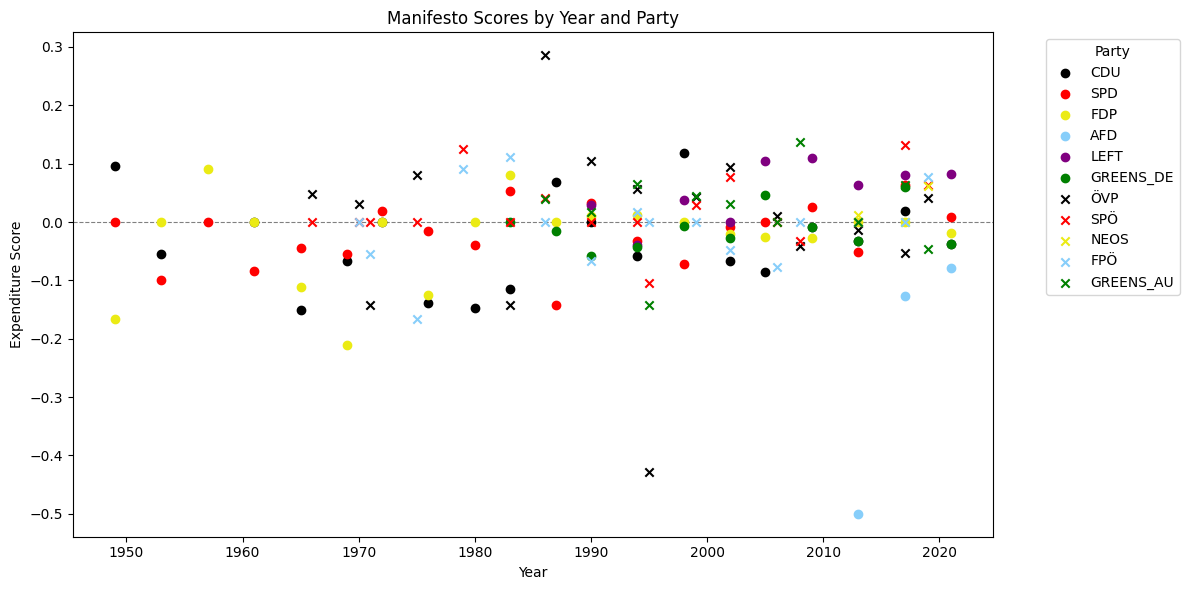

In [145]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(12, 6))
for party, color in party_colors.items():
    party_data = manifesto_scores[manifesto_scores['party'] == party]
    country = party_data['country'].iloc[0]
    if country == 'DE':
        marker = 'o' 
    else:
        marker = 'x'
    plt.scatter(
        party_data['year'], 
        party_data['Expenditure score'], 
        label=party, 
        color=[c / 255 for c in color],
        marker= marker,
        zorder=2
    )

plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8, zorder=-1)
# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Expenditure Score')
plt.title('Manifesto Scores by Year and Party')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()